In [2]:
!pip freeze > requirements.txt

In [38]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import sentencepiece
import torch
from sentence_splitter import SentenceSplitter
import evaluate
import pandas as pd
from tqdm import tqdm

In [210]:
# Load data

test_data = pd.read_parquet('../datasets/test_set/test_dataset.parquet')
test_data = test_data.drop(columns=['#2 String', 'label'])
test_data = test_data.iloc[0:10]

In [211]:
test_data.dropna(inplace=True)

In [212]:
test_data

,#1 String
0,This was a series of nested angular standards ...
1,His father emigrated to Missouri in 1868 but r...
2,"In January 2011 , the Deputy Secretary General..."
3,"Steiner argued that , in the right circumstanc..."
4,"Luciano Williames Dias ( born July 25 , 1970 )..."
5,"During her sophomore , junior and senior summe..."
6,The smallest number that can be represented in...
7,"His father emigrated to Missouri in 1868 , but..."
8,The Villa Pesquera facilities are owned by the...
9,It is situated south of Köroğlu Mountains and ...


In [108]:

# Load metric form HuggingFace {BLUESCORE, TERSORE, ROUGE, METEOR, SACREBLEU}

# 'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}
bleu = evaluate.load('bleu')
# {'score': ter_score, 'num_edits': num_edits, 'ref_length': ref_length}
ter = evaluate.load('ter')
rouge = evaluate.load('rouge')  # ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
meteor = evaluate.load('meteor')  # Its values range from 0 to 1
# score: BLEU score | counts: Counts | totals: Totals | precisions: Precisions | bp: Brevity penalty | sys_len: predictions length | ref_len: reference length
sacrebleu = evaluate.load('sacrebleu')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [178]:
def eval(predict_text, reference_text):

    BLUE_score = bleu.compute(**{
        'predictions': predict_text,
        'references': [reference_text]
    })
    TER_score = ter.compute(**{
        'predictions': predict_text,
        'references': [reference_text]
    })
    ROUGE_score = rouge.compute(**{
        'predictions': predict_text,
        'references': [reference_text]
    })
    METEOR_score = meteor.compute(**{
        'predictions': predict_text,
        'references': [reference_text]
    })
    SACREBLUE_score = sacrebleu.compute(**{
        'predictions': predict_text,
        'references': [reference_text]
    })

    return BLUE_score, TER_score, ROUGE_score, METEOR_score, SACREBLUE_score

## OWN MODEL

In [110]:

# LOAD MODEL, Tokenizer YOUR

model_orign = "ThanhJamieAI/ParapharseV8_8E_4B"
tokenizer = PegasusTokenizer.from_pretrained(model_orign)
model = PegasusForConditionalGeneration.from_pretrained(model_orign).to(device)

In [135]:
progress_bar.close()

  0%|          | 16/10081 [00:36<6:26:21,  2.30s/it, BLUE_score: 0.578, TER_score 54.545, ROUGE1_score 0.765, ROUGEL_score 0.765, METEOR_score 0.749,SACREBLUE_score: 57.755]


In [134]:
progress_bar = tqdm(range(0, len(test_data)))
dict_in_dict = {}
for i in range(len(test_data)):
    sentence = test_data.loc[i, "#1 String"]
    sentence = str(sentence)
    batch = tokenizer(sentence, truncation=True, padding='longest',
                      max_length=100, return_tensors="pt").to(device)
    translated = model.generate(**batch, max_length=1024, num_beams=3,
                                num_return_sequences=1, temperature=1.5, do_sample=True)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    BLUE_score, TER_score, ROUGE_score, METEOR_score, SACREBLUE_score = eval(
        predict_text=tgt_text, reference_text=sentence)
    dict_in_dict[i] = {
        "text": f"{sentence}",
        "parapharse": f"{tgt_text[0]}",
        "BLUE_score": BLUE_score['bleu'],
        "TER_score": TER_score['score'],
        "ROUGE1_score": ROUGE_score['rouge1'],
        "ROUGEL_score": ROUGE_score['rougeL'],
        "METEOR_score": METEOR_score['meteor'],
        "SACREBLUE_score": SACREBLUE_score['score'],
    }
    progress_bar.update(1)
    progress_bar.set_postfix_str(
        f"BLUE_score: {BLUE_score['bleu']:.3f}, TER_score {TER_score['score']:.3f}, ROUGE1_score {ROUGE_score['rouge1']:.3f}, ROUGEL_score {ROUGE_score['rougeL']:.3f}, METEOR_score {METEOR_score['meteor']:.3f},SACREBLUE_score: { SACREBLUE_score['score']:.3f}", refresh=True)
progress_bar.close()

  0%|          | 16/10081 [00:34<6:09:36,  2.20s/it, BLUE_score: 0.578, TER_score 54.545, ROUGE1_score 0.765, ROUGEL_score 0.765, METEOR_score 0.749,SACREBLUE_score: 57.755]

KeyboardInterrupt: 

In [94]:
dict_in_dict

{1: {'text': 'This was a series of nested angular standards , so that measurements in azimuth and elevation could be done directly in polar coordinates relative to the ecliptic .',
  'parapharse': 'This was a series of nested standards, so measurements in azimuth and elevation could be done directly in polar coordinates relative to the ecliptic.',
  'BLUE_score': 0.8033867204961556,
  'TER_score': 21.428571428571427,
  'ROUGE1_score': 0.9600000000000001,
  'ROUGEL_score': 0.9600000000000001,
  'METEOR_score': 0.9345334383380869,
  'SACREBLUE_score': 80.3386720496156},
 2: {'text': 'His father emigrated to Missouri in 1868 but returned when his wife became ill and before the rest of the family could also go to America .',
  'parapharse': 'His father emigrated to Missouri in 1868, but returned when his wife became ill and the rest of the family could also leave America.',
  'BLUE_score': 0.6988909238965656,
  'TER_score': 22.22222222222222,
  'ROUGE1_score': 0.9199999999999999,
  'ROUGEL

""


In [104]:
import pandas as pd

# Create an empty list to store the data
data = []

# Iterate over the nested dictionary
for key, value in dict_in_dict.items():
    # Extract the relevant data from the dictionary value
    text = value['text']
    paraphrase = value['parapharse']
    BLUE_score = value['BLUE_score']
    TER_score = value['TER_score']
    ROUGE1_score = value['ROUGE1_score']
    ROUGEL_score = value['ROUGEL_score']
    METEOR_score = value['METEOR_score']
    SACREBLUE_score = value['SACREBLUE_score']

    # Create a dictionary with the extracted data
    data_row = {
        'text': text,
        'paraphrase': paraphrase,
        'BLUE_score': BLUE_score,
        'TER_score': TER_score,
        'ROUGE1_score': ROUGE1_score,
        'ROUGEL_score': ROUGEL_score,
        'METEOR_score': METEOR_score,
        'SACREBLUE_score': SACREBLUE_score
    }

    # Append the dictionary to the list
    data.append(data_row)

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                                                text  \
0  This was a series of nested angular standards ...   
1  His father emigrated to Missouri in 1868 but r...   
2  In January 2011 , the Deputy Secretary General...   
3  Steiner argued that , in the right circumstanc...   
4  Luciano Williames Dias ( born July 25 , 1970 )...   
5  During her sophomore , junior and senior summe...   
6  The smallest number that can be represented in...   
7  His father emigrated to Missouri in 1868 , but...   
8  The Villa Pesquera facilities are owned by the...   
9  It is situated south of Köroğlu Mountains and ...   

                                          paraphrase  BLUE_score  TER_score  \
0  This was a series of nested standards, so meas...    0.803387  21.428571   
1  His father emigrated to Missouri in 1868, but ...    0.698891  22.222222   
2  In January 2011, the Deputy Secretary General ...    0.622205  33.333333   
3  Steiner argued that in the right circumstances...    0.814787  2

In [105]:
df.to_csv('EDA_model_ThanhJamieAI8E4B', index=False)

,text,paraphrase,BLUE_score,TER_score,ROUGE1_score,ROUGEL_score,METEOR_score,SACREBLUE_score
0,This was a series of nested angular standards ...,"This was a series of nested standards, so meas...",0.803387,21.428571,0.960000,0.960000,0.934533,80.338672
1,His father emigrated to Missouri in 1868 but r...,"His father emigrated to Missouri in 1868, but ...",0.698891,22.222222,0.920000,0.920000,0.885223,69.889092
2,"In January 2011 , the Deputy Secretary General...","In January 2011, the Deputy Secretary General ...",0.622205,33.333333,0.954545,0.954545,0.878939,62.220458
3,"Steiner argued that , in the right circumstanc...",Steiner argued that in the right circumstances...,0.814787,21.428571,0.961538,0.961538,0.967545,81.478655
4,"Luciano Williames Dias ( born July 25 , 1970 )...","Luciano Williames Dias ( born July 25, 1970 ) ...",1.000000,21.052632,1.000000,1.000000,0.999927,100.000000
5,"During her sophomore , junior and senior summe...","During her senior, junior and junior summers s...",0.531547,28.571429,0.956522,0.913043,0.843581,53.154749
6,The smallest number that can be represented in...,The smallest number that can be represented in...,0.917318,8.695652,0.954545,0.954545,0.956162,91.731764
7,"His father emigrated to Missouri in 1868 , but...","In 1868, his father emigrated to Missouri, but...",0.703282,33.333333,0.938776,0.857143,0.919526,70.328179
8,The Villa Pesquera facilities are owned by the...,Villa Pesquera facilities are owned by the mun...,0.688837,31.578947,0.941176,0.941176,0.942170,68.883651
9,It is situated south of Köroğlu Mountains and ...,It is located south of the Krolu Mountains and...,0.274225,42.857143,0.740741,0.666667,0.754207,27.422490


## T5 Model

In [136]:


from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")

''' 
uncomment to get reproducable paraphrase generations
def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)
'''

#Init models (make sure you init ONLY once if you integrate this to your code)
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

phrases = ["Can you recommed some upscale restaurants in Newyork?"]

for phrase in phrases:
  print("-"*100)
  print("Input_phrase: ", phrase)
  print("-"*100)
  para_phrases = parrot.augment(input_phrase=phrase)
  for para_phrase in para_phrases:
   print(para_phrase)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


----------------------------------------------------------------------------------------------------
Input_phrase:  Can you recommed some upscale restaurants in Newyork?
----------------------------------------------------------------------------------------------------
('can you recommend some high end restaurants in new york?', 22)
('can you recommend some of the upscale restaurants in new york?', 21)
('can you recommend some luxury restaurants in new york?', 21)
('can you recommend some best upscale restaurants in new york?', 19)
('can you recommend some upscale restaurants in new york?', 14)
('can you recommend some upscale restaurants in newyork?', 13)


In [138]:
test = "Can you recommed some upscale restaurants in Newyork?"

In [156]:
para_phrases = parrot.augment(input_phrase=phrase, 
                               diversity_ranker="levenshtein",
                               do_diverse=False, 
                               max_return_phrases = 1, 
                               max_length=32, 
                               adequacy_threshold = 0.5, 
                               fluency_threshold = 0.5)

In [167]:
str(para_phrases[0][0])

'recommend some of the best and expensive restaurants in new york?'

In [168]:
print(para_phrases[0][0])

recommend some of the best and expensive restaurants in new york?


In [182]:
progress_bar.close()

In [186]:
progress_bar = tqdm(range(0, len(test_data)))
dict_in_dict = {}
for i in range(len(test_data)):
    sentence = test_data.loc[i, "#1 String"]
    sentence = str(sentence)
    para_phrases = parrot.augment(input_phrase=sentence, 
                               diversity_ranker="levenshtein",
                               do_diverse=False, 
                               max_return_phrases = 1, 
                               max_length=32, 
                               adequacy_threshold = 0.5, 
                               fluency_threshold = 0.5)
    if para_phrases is not None:
        BLUE_score, TER_score, ROUGE_score, METEOR_score, SACREBLUE_score = eval(
            predict_text=[para_phrases[0][0]], reference_text=sentence)
        dict_in_dict[i] = {
            "text": f"{sentence}",
            "parapharse": f"{para_phrases[0][0]}",
            "BLUE_score": BLUE_score['bleu'],
            "TER_score": TER_score['score'],
            "ROUGE1_score": ROUGE_score['rouge1'],
            "ROUGEL_score": ROUGE_score['rougeL'],
            "METEOR_score": METEOR_score['meteor'],
            "SACREBLUE_score": SACREBLUE_score['score'],
        }
        progress_bar.update(1)
        progress_bar.set_postfix_str(
            f"BLUE_score: {BLUE_score['bleu']:.3f}, TER_score {TER_score['score']:.3f}, ROUGE1_score {ROUGE_score['rouge1']:.3f}, ROUGEL_score {ROUGE_score['rougeL']:.3f}, METEOR_score {METEOR_score['meteor']:.3f},SACREBLUE_score: { SACREBLUE_score['score']:.3f}", refresh=True)
    else: 
         dict_in_dict[i] = {
            "text": f"{sentence}",
            "parapharse": None,
            "BLUE_score": None,
            "TER_score": None,
            "ROUGE1_score": None,
            "ROUGEL_score": None,
            "METEOR_score": None,
            "SACREBLUE_score": None,
        }
        
progress_bar.close()
print("!!!Done!!!")

 90%|█████████ | 9/10 [00:20<00:02,  2.32s/it, BLUE_score: 0.293, TER_score 35.714, ROUGE1_score 0.774, ROUGEL_score 0.774, METEOR_score 0.838,SACREBLUE_score: 29.347]

!!!Done!!!


In [187]:
dict_in_dict

{0: {'text': 'This was a series of nested angular standards , so that measurements in azimuth and elevation could be done directly in polar coordinates relative to the ecliptic .',
  'parapharse': None,
  'BLUE_score': None,
  'TER_score': None,
  'ROUGE1_score': None,
  'ROUGEL_score': None,
  'METEOR_score': None,
  'SACREBLUE_score': None},
 1: {'text': 'His father emigrated to Missouri in 1868 but returned when his wife became ill and before the rest of the family could also go to America .',
  'parapharse': 'his father emigrated to missouri in 1868 but returned when his wife became ill and before the rest of the family could also go to america',
  'BLUE_score': 0.7813950770601232,
  'TER_score': 3.7037037037037033,
  'ROUGE1_score': 1.0,
  'ROUGEL_score': 1.0,
  'METEOR_score': 0.9665152548338136,
  'SACREBLUE_score': 78.13950770601237},
 2: {'text': 'In January 2011 , the Deputy Secretary General of FIBA Asia , Hagop Khajirian , inspected the venue together with SBP - President M

## PEGASUS Tunner 

In [190]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

def get_response(input_text,num_return_sequences,num_beams):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [214]:
progress_bar.close()

 10%|█         | 1/10 [00:12<01:48, 12.10s/it, BLUE_score: 0.000, TER_score 100.000, ROUGE1_score 0.000, ROUGEL_score 0.000, METEOR_score 0.019,SACREBLUE_score: 0.799]


In [215]:
progress_bar = tqdm(range(0, len(test_data)))
dict_in_dict = {}
for i in range(len(test_data)):
    sentence = test_data.loc[i, "#1 String"]
    sentence = str(sentence)
    output  = get_response(sentence,1,3)
    if tgt_text is not None:
        BLUE_score, TER_score, ROUGE_score, SACREBLUE_score = eval(
            predict_text=tgt_text, reference_text=sentence)
        dict_in_dict[i] = {
            "text": f"{sentence}",
            "parapharse": f"{tgt_text[0]}",
            "BLUE_score": BLUE_score['bleu'],
            "TER_score": TER_score['score'],
            "ROUGE1_score": ROUGE_score['rouge1'],
            "ROUGE2_score": ROUGE_score['rouge2'],
            "ROUGEL_score": ROUGE_score['rougeL'],
            "SACREBLUE_score": SACREBLUE_score['score'],
        }
        progress_bar.update(1)
        progress_bar.set_postfix_str(
            f"BLUE_score: {BLUE_score['bleu']:.3f}, TER_score {TER_score['score']:.3f}, ROUGE1_score {ROUGE_score['rouge1']:.3f}, ROUGE2_score {ROUGE_score['rouge2']:.3f}, ROUGEL_score {ROUGE_score['rougeL']:.3f},SACREBLUE_score: { SACREBLUE_score['score']:.3f}", refresh=True)
    else: 
         dict_in_dict[i] = {
            "text": f"{sentence}",
            "parapharse": None,
            "BLUE_score": None,
            "TER_score": None,
            "ROUGE1_score": None,
            "ROUGE2_score": None,
            "ROUGEL_score": None,
            "SACREBLUE_score": None,
        }
        
progress_bar.close()
print("!!!Done!!!")

100%|██████████| 10/10 [00:20<00:00,  2.04s/it, BLUE_score: 0.000, TER_score 100.000, ROUGE1_score 0.000, ROUGEL_score 0.000, METEOR_score 0.036,SACREBLUE_score: 2.853]

!!!Done!!!


In [216]:
dict_in_dict

{0: {'text': 'This was a series of nested angular standards , so that measurements in azimuth and elevation could be done directly in polar coordinates relative to the ecliptic .',
  'parapharse': 'site; like online who),lyge his get lookingh',
  'BLUE_score': 0.0,
  'TER_score': 100.0,
  'ROUGE1_score': 0.0,
  'ROUGEL_score': 0.0,
  'METEOR_score': 0.019011406844106463,
  'SACREBLUE_score': 0.7990819669882756},
 1: {'text': 'His father emigrated to Missouri in 1868 but returned when his wife became ill and before the rest of the family could also go to America .',
  'parapharse': 'site; like go though who),lyge his get lookingh',
  'BLUE_score': 0.0,
  'TER_score': 96.29629629629629,
  'ROUGE1_score': 0.1142857142857143,
  'ROUGEL_score': 0.05714285714285715,
  'METEOR_score': 0.058823529411764705,
  'SACREBLUE_score': 1.15382592527539},
 2: {'text': 'In January 2011 , the Deputy Secretary General of FIBA Asia , Hagop Khajirian , inspected the venue together with SBP - President Manue

In [196]:
num_beams = 3
num_return_sequences = 1
context = "The ultimate test of your knowledge is your capacity to convey it to another."
get_response(context,num_return_sequences,num_beams)

['The test of your knowledge is your ability to convey it.']

## Visual Model

In [217]:
eda_model_owner = pd.read_csv('./EDA_model_ThanhJamieAI8E4B.csv')

In [219]:
eda_model_owner['TER_score'] = 100 - eda_model_owner['TER_score'].astype(float)  

In [220]:
eda_model_owner

,text,paraphrase,BLUE_score,TER_score,ROUGE1_score,ROUGE2_score,ROUGEL_score,SACREBLUE_score
0,This was a series of nested angular standards ...,This was a series of nested orthogonal standar...,0.803226,78.571429,0.941176,0.857143,0.941176,80.322636
1,His father emigrated to Missouri in 1868 but r...,"His father emigrated to Missouri in 1868, but ...",0.698891,77.777778,0.920000,0.833333,0.920000,69.889092
2,"In January 2011 , the Deputy Secretary General...","In January 2011, the Deputy Secretary General ...",0.615079,70.370370,0.954545,0.904762,0.954545,61.507859
3,"Steiner argued that , in the right circumstanc...",Steiner argued that in the right circumstances...,0.814787,78.571429,0.961538,0.920000,0.961538,81.478655
4,"Luciano Williames Dias ( born July 25 , 1970 )...",Luciano Williames Dias ( born 25 July 1970 ) i...,0.757765,78.947368,1.000000,0.785714,0.933333,75.776546
...,...,...,...,...,...,...,...,...
4995,"At the end of the Panthers next possession , C...","At the end of the Panthers's next possession, ...",0.906187,81.481481,0.981132,0.941176,0.981132,90.618744
4996,It was held in Wisconsin in 2015 and 2016 and ...,It was held in Wisconsin in 2015 and 2016 and ...,0.721399,77.777778,0.941176,0.812500,0.823529,72.139899
4997,Lamas is the capital city of the province of L...,Lamas is the capital city of the province of L...,0.849233,84.210526,0.918919,0.857143,0.918919,84.923266
4998,"At club level , Latin America has not develope...","At club level, Latin America has not developed...",1.000000,81.818182,1.000000,1.000000,1.000000,100.000000


In [249]:
eda_model_owner.describe().to_csv('EDA_model_ThanhJamieAI8E4B_describe.csv', index=False)

AttributeError: module 'matplotlib.pyplot' has no attribute 'lowess'

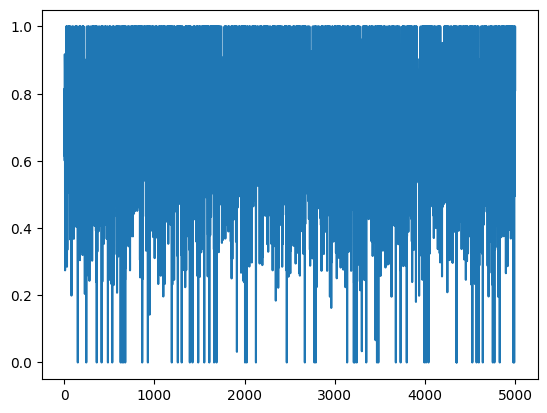

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
# Change the color of the line
plt.plot(eda_model_owner["text"].index, eda_model_owner["BLUE_score"])

# Add y smothing
y_smooth = plt.lowess(eda_model_owner["BLUE_score"], span=0.2)
plt.plot(y_smooth[:, 0], y_smooth[:, 1], color="red")

# Add labels to the axes
plt.xlabel("Line number")
plt.ylabel("BLUE score")

# Show the plot
plt.show()
